# Create new utility function

Import data.

In [1]:
%load_ext autoreload
%autoreload 2

import rdkit
rdkit.Chem.Draw.IPythonConsole.ipython_maxProperties = -1

import dgym as dg

# load all data
print('load data')
path = '../../dgym-data'

deck = dg.MoleculeCollection.from_sdf(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

reactions = dg.ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)

load data


In [2]:
building_blocks = dg.datasets.enamine(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/out/Enamine_Building_Blocks_Stock_262336cmpd_20230630.fpb')

# align fingerprints to building blocks
print('align fingerprints')
fingerprints = dg.utils.sort_fingerprints(fingerprints, building_blocks)

# partition building blocks according to functional groups
print('partition building blocks')
templates = dg.utils.get_unique_reactants(reactions)
building_blocks = dg.utils.partition_building_blocks(building_blocks, templates, out_dir=path)

align fingerprints
partition building blocks


In [45]:
from dgym.envs.library_designer import LibraryDesigner
from dgym.envs.oracle import DGLOracle, RDKitOracle

library_designer = LibraryDesigner(
    reactions,
    building_blocks,
    fingerprints
)

# lipo_oracle = DGLOracle('GCN_canonical_Lipophilicity')
lipo_oracle = RDKitOracle('MolLogP')
esol_oracle = DGLOracle('GCN_canonical_ESOL')

Get some data on the deck.

In [527]:
import numpy as np

# Redefining the Gaussian function
def gaussian(x, mu, sigma, A=1):
    """Computes the Gaussian function for a given x."""
    return A * np.exp(-(x - mu)**2 / (2 * (sigma**2 + 0.001))) # prevent division by 0

class PropertyEvaluator:
    def __init__(self, ideal, acceptable):
        self.ideal = ideal
        self.acceptable = acceptable
        self.mu_acceptable = np.mean(acceptable)
        self.sigma_acceptable = (acceptable[1] - acceptable[0]) / 2
    
    def score(self, value):
        if self.ideal[0] <= value <= self.ideal[1]:
            return 1
        return 0.9 * gaussian(value, self.mu_acceptable, self.sigma_acceptable)

class MoleculeScorer:
    def __init__(self, evaluators):
        """Initializes with a list of PropertyEvaluator instances."""
        self.evaluators = evaluators
    
    def score(self, values):
        """Compute the score for a molecule based on its properties."""
        if not values: return None
        scores = [evaluator.score(val)
                  for evaluator, val
                  in zip(self.evaluators, values)]
        return np.prod(scores)
    
# Define evaluators for log S and log P
log_S_evaluator = PropertyEvaluator(
    ideal=(-2, 0),
    acceptable=(-4, 0.5)
)

# Define evaluators for log S and log P
log_P_evaluator = PropertyEvaluator(
    ideal=(1, 4),
    acceptable=(0, 5)
)

scorer = MoleculeScorer([log_S_evaluator, log_P_evaluator])

First, set up the environment.

In [528]:
# inputs
chosen_molecules = [10]
assays = [esol_oracle, lipo_oracle]

# instantiate drug_env
drug_env = DrugEnv(
    library_designer,
    library = deck[chosen_molecules],
    assays = assays,
    budget = 100_000
)

# housekeeping
assay_results = [assay(drug_env.library) for assay in assays]
utility = np.array([
    scorer.score(properties)
    for properties in zip(*assay_results)
])

best_observed = max(utility)
best_over_time = [best_observed]
dist_over_time = [sorted(utility)]

print(drug_env.library)

MoleculeCollection with 1 Molecules


In [529]:
from dgym.envs import DrugEnv

dists = []

num_trials = 20
for _ in range(num_trials):
    
    print(_, '\t', drug_env.library, '\t', best_observed)

    # ideate
    action = {
        'design': {
            'molecules': chosen_molecules,
            'num_analogs': 1, # maps to 10 molecules
            'fraction_random': 0.0
        }
    }
    library = drug_env.step(action)[0]

    # score
    assay_results = [assay(library) for assay in assays]
    utility = np.array([
        scorer.score(properties)
        for properties in zip(*assay_results)
    ])

    # triage
    chosen_molecules = utility.argsort()[-5:].tolist()
    if len(library) > 100:
        chosen_molecules.extend(random.sample(range(len(library)), 2))

    # housekeeping
    best_observed = max([*utility, best_observed])
    best_over_time.append(best_observed)
    dist_over_time.append(utility[chosen_molecules])

    # assay
    drug_env.step({'order': {'assay': 0, 'molecules': chosen_molecules}})
    drug_env.step({'order': {'assay': 1, 'molecules': chosen_molecules}})

    if best_observed == 1.0:
        break
    
    # update model (TODO)

0 	 MoleculeCollection with 1 Molecules 	 0.8826446440976071
1 	 MoleculeCollection with 1 Molecules 	 0.8826446440976071


In [530]:
from collections import Counter

original_inspirations = []
for mol in drug_env.library:
    while mol.inspiration:
        mol = mol.inspiration
    original_inspirations.append(mol)
    
Counter([o.mol for o in original_inspirations]).most_common(20)

[(<rdkit.Chem.rdchem.Mol at 0x7f5ebb29c890>, 78)]

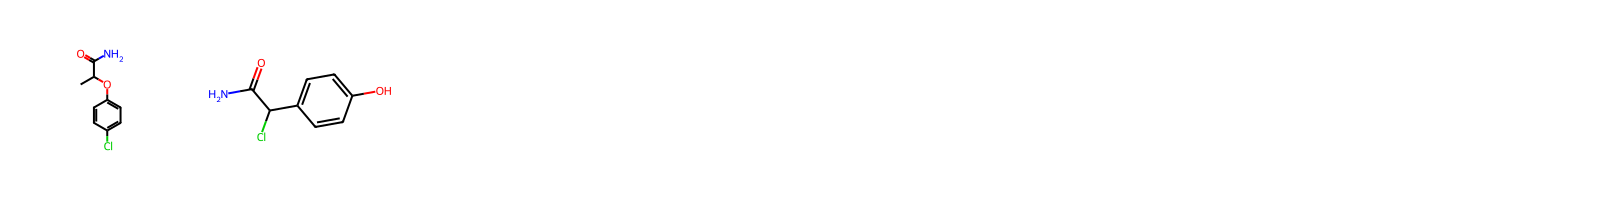

0.8826446440976071		1
(-2.1940650939941406, 1.5925999999999996)	(-1.4714072942733765, 1.1574)


In [543]:
from rdkit.Chem import Draw

index = int(utility.argsort()[-20])

mol = drug_env.library[index]
lineage = [mol]
while mol.inspiration:
    mol = mol.inspiration
    lineage.insert(0, mol)

assay_results = [assay(lineage) for assay in assays]
results = [
    scorer.score(properties)
    for properties in zip(*assay_results)
]

display(Draw.MolsToGridImage(
    [m.mol for m in lineage],
    molsPerRow=8,
    maxMols=10_000
))

print('\t\t'.join(map(str, results)))
print('\t'.join(map(str, zip(*assay_results))))

In [205]:
scorer.score([
    mol.annotations['MolLogP'],
    mol.annotations['GCN_canonical_ESOL']
])

0.16583828252763624

In [ ]:
lipo_oracle([lineage[-1]])

[2.2407000000000004]

<Axes: >

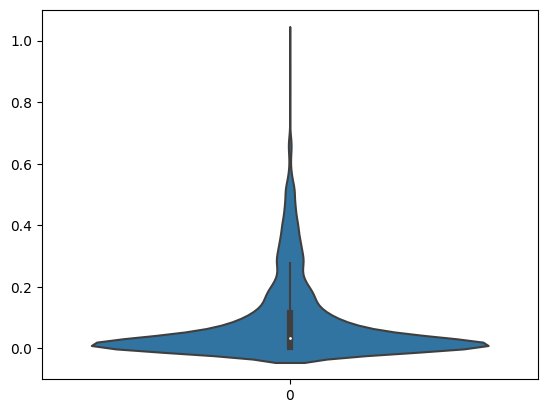

In [ ]:
import seaborn as sns

sns.violinplot(utility)

In [23]:
# score
assay_results = []
for assay in assays:
    assay_results.append(np.array(assay.predict(library)))
utility = composite_score(*assay_results)

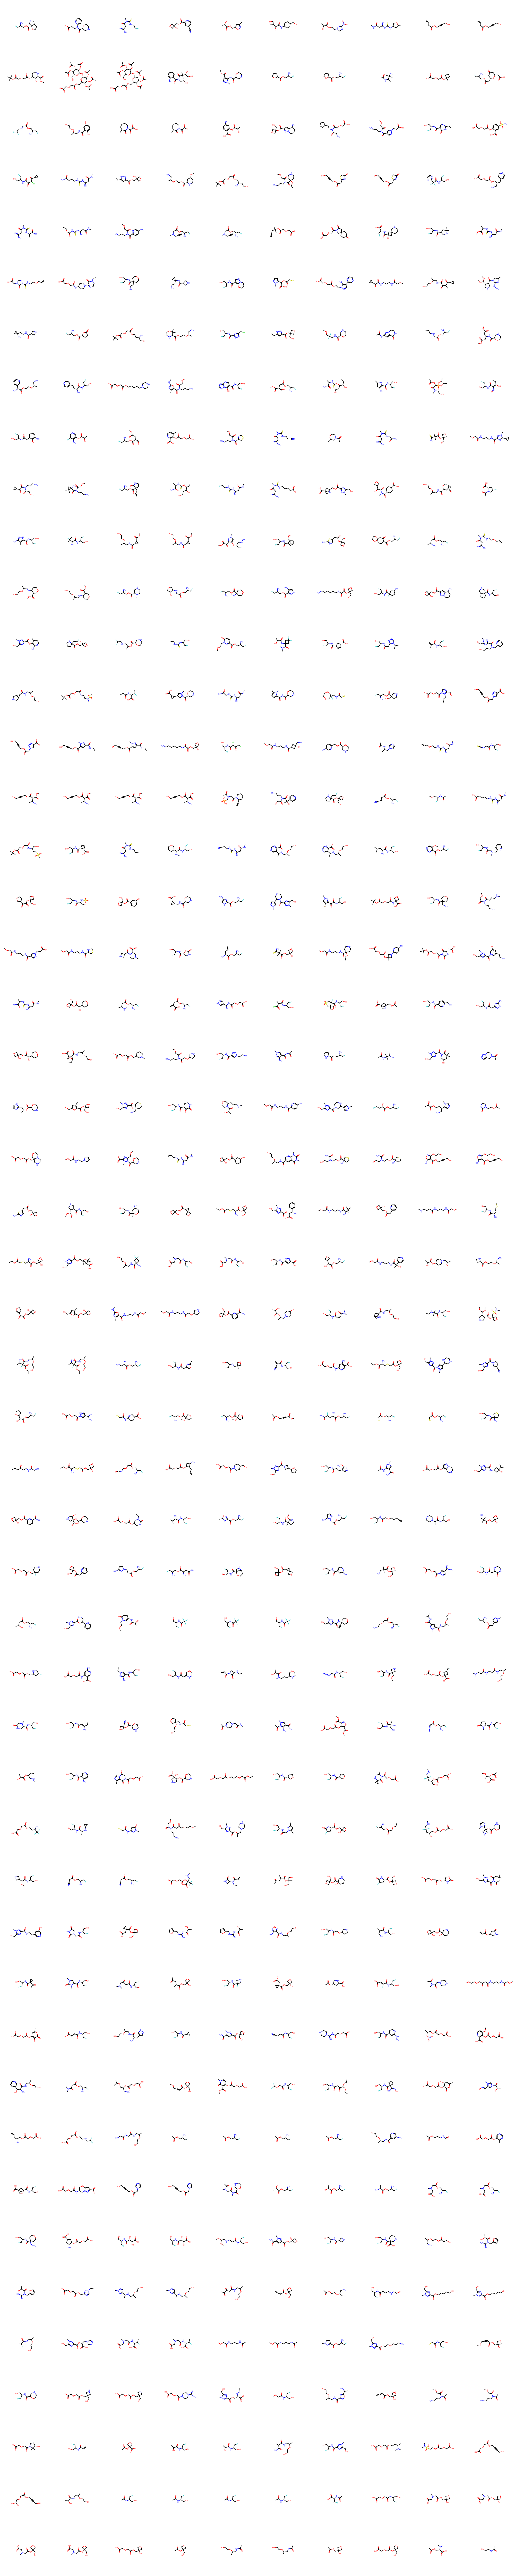

In [180]:
from rdkit.Chem import Draw

Draw.MolsToGridImage(
    [m.update_cache().mol for m in library[utility.argsort()][-500:]],
    molsPerRow=10,
    maxMols=10_000
)

<Axes: >

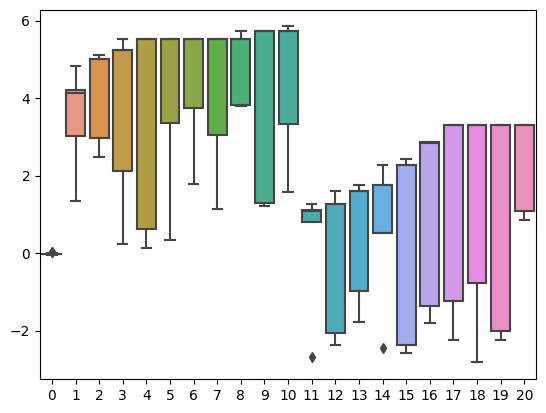

In [38]:
sns.boxplot(dist_over_time)

In [32]:
from dgym.agents import DrugAgent

In [33]:
drug_agent = DrugAgent(drug_env.action_space)